Importando libs

In [140]:

from sklearn.preprocessing import LabelBinarizer
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

Carregando Dataframes

In [141]:
df_train = pd.read_csv('./data/conjunto_de_treinamento.csv')
df_test = pd.read_csv('./data/conjunto_de_teste.csv')

Verificando Balanceamento

In [142]:
print('Bom Pagador: %f%% inadimplente: %f%%'%(df_train[df_train['inadimplente']==0].shape[0]/df_train.shape[0]*100,df_train[df_train['inadimplente']==1].shape[0]/df_train.shape[0]*100))

Bom Pagador: 50.000000% inadimplente: 50.000000%


Removendo Colunas Ruins

In [143]:
to_be_removed = ['grau_instrucao', 'estado_onde_nasceu', 'codigo_area_telefone_residencial',
                 'estado_onde_trabalha', 'codigo_area_telefone_trabalho',
                 'profissao', 'profissao_companheiro', 'grau_instrucao_companheiro', 'local_onde_reside',
                 'local_onde_trabalha', 'nacionalidade']

df_train = df_train.drop(to_be_removed, axis=1)
df_test = df_test.drop(to_be_removed, axis=1)

Criando variáveis de Região para aplicar one hot encoding

In [144]:
def get_region_from_uf(row):
    UF = row['estado_onde_reside']
    map = {
        'SP': 'Sudeste',
        'BA': 'Nordeste',
        'RS': 'Sul',
        'CE': 'Nordeste',
        'PE': 'Nordeste',
        'MG': 'Sudeste',
        'PA': 'Nordeste',
        'RJ': 'Sudeste',
        'RN': 'Nordeste',
        'GO': 'Centro-Oeste',
        'PR': 'Sul',
        'AL': 'Nordeste',
        'MT': 'Centro-Oeste',
        'PB': 'Nordeste',
        'MA': 'Nordeste',
        'DF': 'Centro-Oeste',
        'MS': 'Centro-Oeste',
        'ES': 'Sudeste',
        'SC': 'Sul',
        'AP': 'Norte',
        'AM': 'Norte',
        'PI': 'Norte',
        'SE': 'Nordeste',
        'RO': 'Norte',
        'AC': 'Norte',
        'TO': 'Norte',
        'RR': 'Norte'
    }
    return map[UF]

df_train['regiao'] = df_train.apply(get_region_from_uf, axis=1)
df_test['regiao'] = df_test.apply(get_region_from_uf, axis=1)
df_train = df_train.drop(columns=['estado_onde_reside'], axis=1)
df_test = df_test.drop(columns=['estado_onde_reside'], axis=1)

Removendo Linhas Irrelevantes do dataset

In [145]:
df_train = df_train[df_train['sexo'] != 'N']
df_train = df_train[df_train['sexo'] != ' ']

Separando variáveis categóricas não binárias e aplicando one hot encoding

In [146]:
binarias = ['sexo', 'possui_telefone_residencial', 'vinculo_formal_com_empresa', 'possui_telefone_trabalho', 'possui_telefone_celular']
categoricas_nao_binarias = ['regiao', 'produto_solicitado', 'forma_envio_solicitacao', 'tipo_endereco', 'estado_civil', 'tipo_residencia', 'ocupacao']

df_train = pd.get_dummies(df_train,columns=categoricas_nao_binarias)
df_test = pd.get_dummies(df_test,columns=categoricas_nao_binarias)

binarizador = LabelBinarizer()

for b in binarias:
    df_train[b] = binarizador.fit_transform(df_train[b])
    df_test[b] = binarizador.fit_transform(df_test[b])


In [147]:
list(set(df_test.columns) - set(df_train.columns))

[]

In [148]:
df_train['sexo'].value_counts()

0    12246
1     7722
Name: sexo, dtype: int64

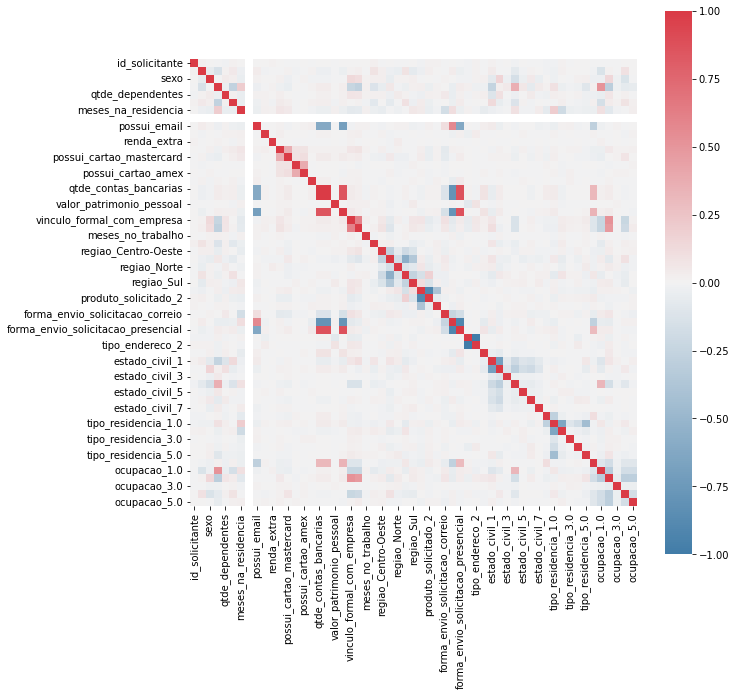

In [149]:
corrMatrix = df_train.corr()
_, _ = plt.subplots(figsize=(10,10)), sn.heatmap(corrMatrix, cmap=sn.diverging_palette(240,10,n=256), vmin=-1, vmax=1, square=True)
plt.show()

Dropando Nulos

In [150]:
df_train = df_train.dropna()

In [151]:
df_test.columns

Index(['id_solicitante', 'dia_vencimento', 'sexo', 'idade', 'qtde_dependentes',
       'possui_telefone_residencial', 'meses_na_residencia',
       'possui_telefone_celular', 'possui_email', 'renda_mensal_regular',
       'renda_extra', 'possui_cartao_visa', 'possui_cartao_mastercard',
       'possui_cartao_diners', 'possui_cartao_amex', 'possui_outros_cartoes',
       'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 'possui_carro',
       'vinculo_formal_com_empresa', 'possui_telefone_trabalho',
       'meses_no_trabalho', 'regiao_Centro-Oeste', 'regiao_Nordeste',
       'regiao_Norte', 'regiao_Sudeste', 'regiao_Sul', 'produto_solicitado_1',
       'produto_solicitado_2', 'produto_solicitado_7',
       'forma_envio_solicitacao_correio', 'forma_envio_solicitacao_internet',
       'forma_envio_solicitacao_presencial', 'tipo_endereco_1',
       'tipo_endereco_2', 'estado_civil_0', 'estado_civil_1', 'estado_civil_2',
       'estado_civil_3', '

Predição de Teste dos hiperparâmetros

In [152]:

x = df_train.loc[:,df_train.columns != 'inadimplente'].to_numpy()
y = df_train.loc[:,'inadimplente'].to_numpy()
clf = GradientBoostingClassifier(max_depth=4, n_estimators=40, random_state=0)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=0)
pred = clf.fit(x_treino,y_treino).predict(x_teste)
print(accuracy_score(y_teste,pred))

0.574244060475162


Preenchendo nulos no dataframe de teste

In [153]:
imputer_test = SimpleImputer(missing_values=np.nan, strategy="median")
df_test = imputer_test.fit_transform(df_test)

Treinando o modelo final

In [154]:
df_test = pd.DataFrame(df_test)
model = clf.fit(x,y)
prediction = model.predict(df_test)
df_args = { 'id_solicitante': df_test[0].astype('int'), 'inadimplente': prediction }
prediction = pd.DataFrame(df_args)
prediction.to_csv('./submission.csv', index=False)